![](https://cienciadosdados.com/images/2023/08/dsmm.png)

## 1° Análise Exploratória

In [ ]:
import pandas as pd
df1 = pd.read_csv("/content/drive/MyDrive/3. Conteúdos/Dados/DSM/item_sales.csv")

In [ ]:
df1

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,SUPERMARKET_3_823_PHI_3,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,2,...,2,0,0,0,0,0,1,0,0,1
30486,SUPERMARKET_3_824_PHI_3,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,SUPERMARKET_3_825_PHI_3,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,6,0,...,2,1,0,2,0,1,0,0,1,0
30488,SUPERMARKET_3_826_PHI_3,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [ ]:
df1.info

In [ ]:
import pandas as pd
df2 = pd.read_csv("/content/drive/MyDrive/3. Conteúdos/Dados/DSM/item_prices.csv")

In [ ]:
df2.head(10)

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330.0,10.9858
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331.0,10.9858
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332.0,10.9858
5,ACCESORIES_1_001,ACCESORIES,NYC_1,201333.0,10.9858
6,ACCESORIES_1_001,ACCESORIES,NYC_1,201334.0,10.9858
7,ACCESORIES_1_001,ACCESORIES,NYC_1,201335.0,10.9858
8,ACCESORIES_1_001,ACCESORIES,NYC_1,201336.0,10.9858
9,ACCESORIES_1_001,ACCESORIES,NYC_1,201337.0,10.9858


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965706 entries, 0 to 6965705
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   item        object 
 1   category    object 
 2   store_code  object 
 3   yearweek    float64
 4   sell_price  float64
dtypes: float64(2), object(3)
memory usage: 265.7+ MB


In [ ]:
import pandas as pd
df3 = pd.read_csv("/content/drive/MyDrive/3. Conteúdos/Dados/DSM/daily_calendar_with_events.csv")

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1913 non-null   object
 1   weekday      1913 non-null   object
 2   weekday_int  1913 non-null   int64 
 3   d            1913 non-null   object
 4   event        26 non-null     object
dtypes: int64(1), object(4)
memory usage: 74.9+ KB


#2° Processamento dos Dados

In [5]:
import pandas as pd
df1 = pd.read_csv("/content/drive/MyDrive/3. Conteúdos/Dados/DSM/item_sales.csv")
df2 = pd.read_csv("/content/drive/MyDrive/3. Conteúdos/Dados/DSM/item_prices.csv")
df3 = pd.read_csv("/content/drive/MyDrive/3. Conteúdos/Dados/DSM/daily_calendar_with_events.csv")

In [6]:
df3

,date,weekday,weekday_int,d,event
0,2011-01-29,Saturday,1,d_1,NaN
1,2011-01-30,Sunday,2,d_2,NaN
2,2011-01-31,Monday,3,d_3,NaN
3,2011-02-01,Tuesday,4,d_4,NaN
4,2011-02-02,Wednesday,5,d_5,NaN
...,...,...,...,...,...
1908,2016-04-20,Wednesday,5,d_1909,NaN
1909,2016-04-21,Thursday,6,d_1910,NaN
1910,2016-04-22,Friday,7,d_1911,NaN
1911,2016-04-23,Saturday,1,d_1912,NaN


In [7]:
# Realizando o "melt" para transformar o df1 de formato largo para longo
df1_melted = df1.melt(id_vars=['id', 'item', 'category', 'department', 'store', 'store_code', 'region'],
                      var_name='d',
                      value_name='sales')

In [8]:
df1_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 9 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   id          object
 1   item        object
 2   category    object
 3   department  object
 4   store       object
 5   store_code  object
 6   region      object
 7   d           object
 8   sales       int64 
dtypes: int64(1), object(8)
memory usage: 3.9+ GB


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1920 entries, id to d_1913
dtypes: int64(1913), object(7)
memory usage: 446.6+ MB


In [ ]:
df1_melted.head(10)

,id,item,category,department,store,store_code,region,d,sales
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
5,ACCESORIES_1_006_NYC_1,ACCESORIES_1_006,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
6,ACCESORIES_1_007_NYC_1,ACCESORIES_1_007,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
7,ACCESORIES_1_008_NYC_1,ACCESORIES_1_008,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,12
8,ACCESORIES_1_009_NYC_1,ACCESORIES_1_009,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,2
9,ACCESORIES_1_010_NYC_1,ACCESORIES_1_010,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0


In [ ]:
# Primeiro, junte df1_melted com df3 para obter a data correspondente a cada 'd'
df1_with_dates = pd.merge(df1_melted, df3[['d', 'date']], on='d', how='left')

# Converta a coluna 'date' para datetime
df1_with_dates['date'] = pd.to_datetime(df1_with_dates['date'])

# Crie uma coluna 'year_month' que representa o ano e o mês
df1_with_dates['year_month'] = df1_with_dates['date'].dt.to_period('M')

# Agora, agrupe por 'year_month' e some as vendas
monthly_sales = df1_with_dates.groupby(['year_month', 'id', 'item', 'category', 'department', 'store', 'store_code', 'region']).sum().reset_index()

# Exibir as primeiras linhas do resultado
monthly_sales.head()


<ipython-input-10-90fdc17ea027>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_sales = df1_with_dates.groupby(['year_month', 'id', 'item', 'category', 'department', 'store', 'store_code', 'region']).sum().reset_index()


,year_month,id,item,category,department,store,store_code,region,sales
0,2011-01,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0
1,2011-01,ACCESORIES_1_001_BOS_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,0
2,2011-01,ACCESORIES_1_001_BOS_3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,0
3,2011-01,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0
4,2011-01,ACCESORIES_1_001_NYC_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,0


In [ ]:
def year_week_to_date(year, week):
    try:
        if pd.notna(year) and pd.notna(week):
            return pd.to_datetime(f"{year}W{week}1", format='%YW%U%w')
    except Exception as e:
        print(f"Error with year: {year}, week: {week}. Exception: {e}")
    return np.nan

df2['date'] = np.vectorize(year_week_to_date)(df2['year_str'], df2['week_str'])

# Crie uma coluna 'year_month' que representa o ano e o mês
df2['year_month'] = df2['date'].dt.to_period('M')

# Agregue df2 para obter o preço médio por 'year_month', 'item', 'category', e 'store_code'
df2_agg = df2.groupby(['year_month', 'item', 'category', 'store_code'])['sell_price'].mean().reset_index()
df2_agg.rename(columns={'sell_price': 'mean_price'}, inplace=True)

# Exibir as primeiras linhas do resultado
df2_agg.head()


,year_month,item,category,store_code,mean_price
0,2011-01,ACCESORIES_1_004,ACCESORIES,BOS_1,5.7722
1,2011-01,ACCESORIES_1_004,ACCESORIES,BOS_2,5.7722
2,2011-01,ACCESORIES_1_004,ACCESORIES,NYC_2,5.7722
3,2011-01,ACCESORIES_1_004,ACCESORIES,NYC_4,5.7722
4,2011-01,ACCESORIES_1_004,ACCESORIES,PHI_1,5.7722


In [ ]:
# Junção dos dataframes
merged_df = pd.merge(monthly_sales, df2_agg, on=['year_month', 'item', 'category', 'store_code'], how='left')

# Exibir as primeiras linhas do resultado
merged_df.head()


,year_month,id,item,category,department,store,store_code,region,sales,mean_price
0,2011-01,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,NaN
1,2011-01,ACCESORIES_1_001_BOS_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,0,NaN
2,2011-01,ACCESORIES_1_001_BOS_3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,0,NaN
3,2011-01,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,NaN
4,2011-01,ACCESORIES_1_001_NYC_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,0,NaN


In [ ]:
merged_df.info()

In [ ]:
merged_df.to_csv('/content/drive/MyDrive/3. Conteúdos/Dados/DSM/base_mensal.csv', index=False)


# 3° Máquinas Preditivas

## <Font color = blue> 1. Agrupamentos

In [ ]:
df.category.value_counts()

SUPERMARKET      919680
HOME_&_GARDEN    670080
ACCESORIES       361600
Name: category, dtype: int64

###Item(prd)

In [ ]:
import pandas as pd

df= pd.read_csv('/content/drive/MyDrive/3. Conteúdos/Dados/DSM/base_mensal.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951360 entries, 0 to 1951359
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   year_month  object 
 1   id          object 
 2   item        object 
 3   category    object 
 4   department  object 
 5   store       object 
 6   store_code  object 
 7   region      object 
 8   sales       int64  
 9   mean_price  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 148.9+ MB


In [ ]:
num_itens = df['item'].nunique()
print(f"Há {num_itens} produtos únicos no dataframe.")


Há 3049 produtos únicos no dataframe.


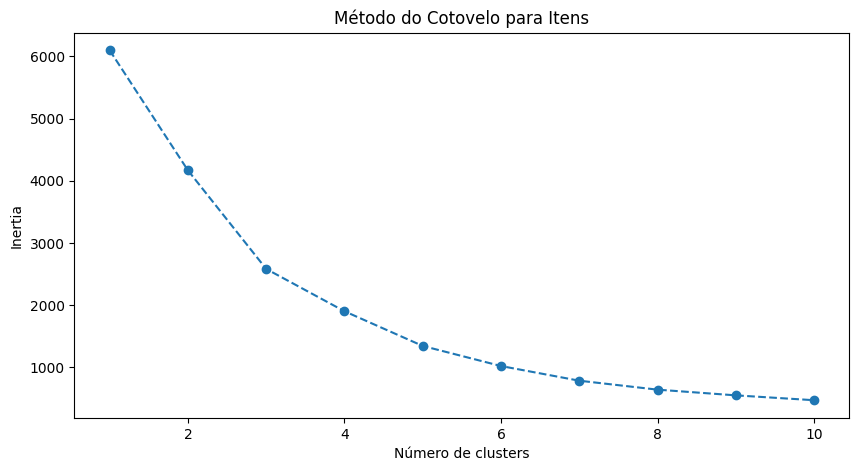

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# 1. Preparação dos dados:

# Agregando dados por item
df_items = df.groupby('item').agg({
    'sales':'sum',
    'mean_price':'mean',
    'store':'nunique',
    'region':'nunique'
}).reset_index()

# Renomeando colunas para melhor clareza
df_items = df_items.rename(columns={
    'store': 'unique_stores',
    'region': 'unique_regions'
})

# Normalização dos dados
features_to_scale = ['sales', 'mean_price', 'unique_stores', 'unique_regions']
scaler = StandardScaler()
df_items_scaled = scaler.fit_transform(df_items[features_to_scale])

# 2. Determinar o número ideal de clusters:

inertia = []
for i in range(1, 11):  # Testando de 1 a 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_items_scaled)
    inertia.append(kmeans.inertia_)

# Plotando o Método do Cotovelo
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método do Cotovelo para Itens')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()


In [ ]:
# Aplicar o K-means com 15 clusters:
kmeans_15 = KMeans(n_clusters=6, random_state=0).fit(df_items_scaled)
df_items['cluster'] = kmeans_15.labels_

# Agora, df_items tem uma nova coluna chamada 'cluster' que indica a qual dos 15 clusters cada item pertence.
df_items

,item,sales,mean_price,unique_stores,unique_regions,cluster
0,ACCESORIES_1_001,4093,11.043783,10,3,2
1,ACCESORIES_1_002,5059,5.276228,10,3,0
2,ACCESORIES_1_003,1435,3.943316,10,3,0
3,ACCESORIES_1_004,39175,5.980907,10,3,0
4,ACCESORIES_1_005,14621,3.834539,10,3,0
...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,15388,3.344793,10,3,0
3045,SUPERMARKET_3_824,8325,3.026134,10,3,0
3046,SUPERMARKET_3_825,13526,4.932795,10,3,0
3047,SUPERMARKET_3_826,12188,1.535816,10,3,0


In [ ]:
import plotly.express as px

# Criando o scatter plot
fig = px.scatter(df_items,
                 x='sales',
                 y='mean_price',
                 color='cluster',
                 hover_data=['item'],
                 title="Distribuição dos Itens nos Clusters")

fig.show()


In [ ]:
from sklearn.metrics import silhouette_score

# Calculando o coeficiente de silhueta
silhouette_avg = silhouette_score(df_items_scaled, df_items['cluster'])

print(f"O coeficiente de silhueta médio para os clusters é: {silhouette_avg:.2f}")


O coeficiente de silhueta médio para os clusters é: 0.51


In [ ]:
import plotly.express as px

# Criando o gráfico de dispersão 3D
fig = px.scatter_3d(df_items,
                    x='sales',
                    y='mean_price',
                    z='unique_stores',
                    color='cluster',
                    labels={'sales': 'Sales', 'mean_price': 'Mean Price', 'unique_stores': 'Unique Stores Sold In'},
                    title="Clusters de Itens em 3D",
                    color_continuous_scale=px.colors.qualitative.Set1,
                    hover_data=['item'])

fig.show()


### Lojas

In [ ]:
import pandas as pd

df= pd.read_csv('/content/drive/MyDrive/3. Conteúdos/Dados/DSM/base_mensal.csv')

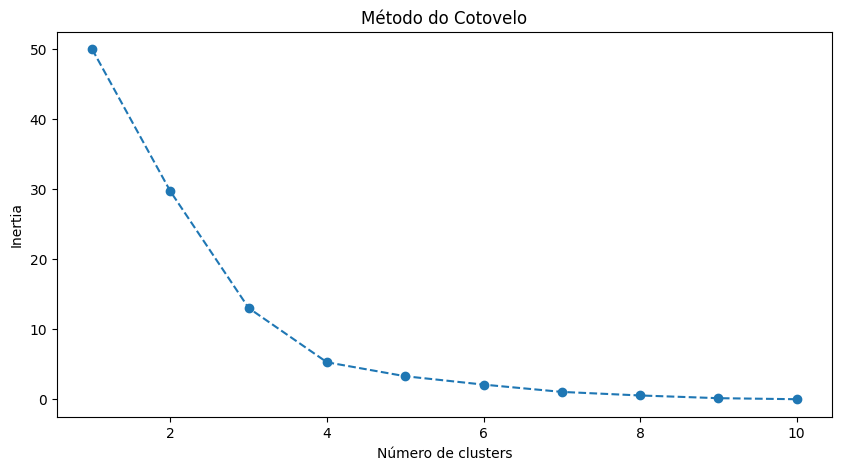

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt

# 1. Preparação dos dados:
# Selecione as características desejadas: sales, mean_price, região e diversidade de produtos por loja.
df_stores = df.groupby(['store', 'region']).agg({'sales':'sum', 'mean_price':'mean', 'item':'nunique'}).reset_index()
df_stores = df_stores.rename(columns={'item': 'unique_products'})

# Codificação One-Hot para a coluna 'region'
df_region_encoded = pd.get_dummies(df_stores['region'], prefix='region')
df_stores = pd.concat([df_stores, df_region_encoded], axis=1)

# Normalização dos dados
features_to_scale = ['sales', 'mean_price', 'unique_products'] + df_region_encoded.columns.tolist()
scaler = StandardScaler()
df_stores_scaled = scaler.fit_transform(df_stores[features_to_scale])

# 2. Determinar o número ideal de clusters:
inertia = []
for i in range(1, 11):  # Testando de 1 a 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_stores_scaled)
    inertia.append(kmeans.inertia_)

# Plotando o Método do Cotovelo
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()


In [ ]:
# 3. Aplicar o K-means com o número ideal de clusters:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_stores_scaled)
df_stores['cluster'] = kmeans.labels_

# Agora, df_stores tem uma nova coluna chamada 'cluster' que indica a qual cluster cada loja pertence.


In [ ]:
df_stores

,store,region,sales,mean_price,unique_products,region_Boston,region_New York,region_Philadelphia,cluster
0,Back_Bay,Boston,6089330,5.481649,3049,1,0,0,2
1,Brooklyn,New York,4103676,5.520030,3049,0,1,0,3
2,Greenwich_Village,New York,7698216,5.513876,3049,0,1,0,4
3,Harlem,New York,5685475,5.574094,3049,0,1,0,3
4,Midtown_Village,Philadelphia,5149062,5.577920,3049,0,0,1,0
5,Queen_Village,Philadelphia,6427782,5.516566,3049,0,0,1,0
6,Roxbury,Boston,7214384,5.453013,3049,1,0,0,2
7,South_End,Boston,5595292,5.461595,3049,1,0,0,2
8,Tribeca,New York,11188180,5.481631,3049,0,1,0,1
9,Yorktown,Philadelphia,6544012,5.553710,3049,0,0,1,0


In [ ]:
import plotly.graph_objects as go

# Criando uma lista para armazenar os dados de cada cluster
data = []

# Iterar através de cada cluster e coletar os nomes das lojas
for cluster in df_stores['cluster'].unique():
    cluster_data = df_stores[df_stores['cluster'] == cluster]
    store_names = cluster_data['store'].tolist()

    # Adicionar os nomes das lojas ao gráfico de barras para esse cluster
    data.append(go.Bar(name=f'Cluster {cluster}', x=[f'Cluster {cluster}'] * len(store_names), y=store_names, orientation='h'))

# Criando o gráfico
fig = go.Figure(data=data)

# Configurações adicionais
fig.update_layout(title_text='Lojas em cada Cluster', barmode='stack', yaxis_categoryorder='total ascending')

fig.show()


In [ ]:
num_stores = df['store'].nunique()
print(f"Há {num_stores} lojas únicas no dataframe.")


Há 10 lojas únicas no dataframe.


In [ ]:
import plotly.express as px

# Criando o gráfico de violino
fig = px.violin(df_stores, y="store", x="cluster", box=True, points="all", title="Distribuição de Lojas por Cluster")

# Mostrando o gráfico
fig.show()


In [ ]:
from sklearn.metrics import silhouette_score

# ...

# Após aplicar o K-means:
silhouette_avg = silhouette_score(df_stores_scaled, df_stores['cluster'])

print(f"O coeficiente de silhueta médio é: {silhouette_avg:.2f}")


O coeficiente de silhueta médio é: 0.53


## <font color = blue >2. Previsão de Vendas

In [ ]:
import pandas as pd

df= pd.read_csv('/content/drive/MyDrive/3. Conteúdos/Dados/DSM/base_mensal.csv')

### Baseline: Previsão por Loja

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Preparando os dados
df['year_month'] = pd.to_datetime(df['year_month'])
df = pd.get_dummies(df, columns=['category', 'store'])  # Apenas 'category' e 'store' para One-Hot

X = df.drop(columns=['sales', 'id', 'year_month', 'item', 'store_code'])

# Definindo o modelo
model = lgb.LGBMRegressor()

# Validação cruzada usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
mape_scorer = make_scorer(MAPE, greater_is_better=False)

mse_scores = cross_val_score(model, X, y, cv=tscv, scoring=mse_scorer)
rmse_scores = cross_val_score(model, X, y, cv=tscv, scoring=rmse_scorer)
mae_scores = cross_val_score(model, X, y, cv=tscv, scoring=mae_scorer)
r2_scores = cross_val_score(model, X, y, cv=tscv, scoring=r2_scorer)
mape_scores = cross_val_score(model, X, y, cv=tscv, scoring=mape_scorer)

print(f"MSE: {-np.mean(mse_scores)}")
print(f"RMSE: {-np.mean(rmse_scores)}")
print(f"MAE: {-np.mean(mae_scores)}")
print(f"R2: {np.mean(r2_scores)}")
print(f"MAPE: {-np.mean(mape_scores)}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 325230, number of used features: 25
[LightGBM] [Info] Start training from score 23.006795
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 650456, number of used features: 25
[LightGBM] [Info] Start training from score 27.918511
[LightGBM] [Warning]

### Previsão por Produto e Loja - Categoria Supermarket

In [2]:
import pandas as pd

df= pd.read_csv('/content/drive/MyDrive/3. Conteúdos/Dados/DSM/base_mensal.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951360 entries, 0 to 1951359
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   year_month  object 
 1   id          object 
 2   item        object 
 3   category    object 
 4   department  object 
 5   store       object 
 6   store_code  object 
 7   region      object 
 8   sales       int64  
 9   mean_price  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 148.9+ MB


In [ ]:
# Agrupando o dataframe por produto e somando as vendas
product_sales = df.groupby('item').sum()['sales']

# Ordenando os produtos pelo total de vendas, em ordem decrescente
sorted_product_sales = product_sales.sort_values(ascending=False)

# Calculando o total cumulativo das vendas
cumulative_sales = sorted_product_sales.cumsum()

# Calculando 80% das vendas totais
sales_80_percent = df['sales'].sum() * 0.8

# Identificando os produtos que compõem os 80% das vendas
top_20_percent_products = cumulative_sales[cumulative_sales <= sales_80_percent].index.tolist()

print(f"Os 20% dos produtos que geram 80% das vendas são: {top_20_percent_products}")


Os 20% dos produtos que geram 80% das vendas são: ['SUPERMARKET_3_090', 'SUPERMARKET_3_586', 'SUPERMARKET_3_252', 'SUPERMARKET_3_555', 'SUPERMARKET_3_714', 'SUPERMARKET_3_587', 'SUPERMARKET_3_694', 'SUPERMARKET_3_226', 'SUPERMARKET_3_202', 'SUPERMARKET_3_723', 'SUPERMARKET_3_120', 'SUPERMARKET_3_635', 'SUPERMARKET_3_808', 'SUPERMARKET_3_377', 'SUPERMARKET_3_541', 'SUPERMARKET_3_080', 'SUPERMARKET_3_318', 'SUPERMARKET_2_360', 'SUPERMARKET_3_234', 'SUPERMARKET_3_681', 'SUPERMARKET_1_218', 'SUPERMARKET_3_376', 'SUPERMARKET_3_607', 'SUPERMARKET_3_099', 'SUPERMARKET_3_319', 'SUPERMARKET_3_752', 'SUPERMARKET_3_295', 'SUPERMARKET_3_804', 'SUPERMARKET_3_501', 'SUPERMARKET_3_491', 'SUPERMARKET_3_462', 'SUPERMARKET_3_711', 'SUPERMARKET_3_282', 'SUPERMARKET_3_007', 'SUPERMARKET_3_547', 'SUPERMARKET_3_030', 'SUPERMARKET_3_811', 'SUPERMARKET_3_281', 'HOME_&_GARDEN_1_334', 'HOME_&_GARDEN_1_459', 'SUPERMARKET_3_389', 'SUPERMARKET_3_498', 'SUPERMARKET_3_458', 'SUPERMARKET_2_197', 'SUPERMARKET_2_276', 

<ipython-input-5-a8099bbf4291>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  product_sales = df.groupby('item').sum()['sales']


In [ ]:
top_20_percent_products

In [3]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Função para calcular o MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Agrupando e filtrando os dados
product_sales = df.groupby('item').sum()['sales']
sorted_product_sales = product_sales.sort_values(ascending=False)
cumulative_sales = sorted_product_sales.cumsum()
sales_80_percent = df['sales'].sum() * 0.8
top_20_percent_products = cumulative_sales[cumulative_sales <= sales_80_percent].index.tolist()
df_supermarket = df[(df['item'].isin(top_20_percent_products)) & (df['category'] == 'SUPERMARKET')]

# Parâmetros para o RandomizedSearchCV
param_dist = {
    'objective': ['regression'],
    'boosting_type': ['gbdt', 'dart'],
    'learning_rate': [0.01, 0.02],
    'n_estimators': [40, 60],
    'seed': [0],
}

model = lgb.LGBMRegressor(verbose=-1)
tscv = TimeSeriesSplit(n_splits=4)

unique_items = df_supermarket['item'].unique()
unique_stores = df_supermarket['store'].unique()

results = []
r2_results = []
all_y = []
all_y_pred = []

for item in unique_items:
    for store in unique_stores:
        subset = df_supermarket[(df_supermarket['item'] == item) & (df_supermarket['store'] == store)]
        X = subset.drop(columns=['sales', 'year_month', 'id', 'item', 'store', 'category'])
        y = subset['sales']

        X = pd.get_dummies(X)
        X = X.replace([np.inf, -np.inf], np.nan)
        X.dropna(axis=1, inplace=True)

        constant_columns = X.columns[X.nunique() == 1]
        X = X.drop(columns=constant_columns)

        if X.shape[1] == 0:
            print(f"No features left for Item {item} and Store {store} after preprocessing. Skipping...")
            continue

        random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=2, scoring='neg_mean_squared_error', cv=tscv, verbose=0)
        random_search.fit(X, y)
        y_pred = random_search.best_estimator_.predict(X)

        all_y.extend(y.tolist())
        all_y_pred.extend(y_pred.tolist())

        # Adicionando o resultado R2 à lista r2_results
        r2 = r2_score(y, y_pred)
        r2_results.append((f"Item {item}, Store {store}", r2))

        for real, predicted in zip(y, y_pred):
            results.append({
                'item': item,
                'store': store,
                'real_value': real,
                'predicted_value': predicted
            })

# Calculando métricas agregadas

mae_general = mean_absolute_error(all_y, all_y_pred)
r2_general = r2_score(all_y, all_y_pred)
rmse_general = np.sqrt(mean_squared_error(all_y, all_y_pred))
metrics_data = {

    'MAE': [mae_general],
    'R2': [r2_general],
    'RMSE': [rmse_general]
}

# Salvando os resultados no Excel
with pd.ExcelWriter('results.xlsx') as writer:
    # Adicionando colunas de erro absoluto e erro percentual ao DataFrame
    df_real_predicted = pd.DataFrame(results)
    df_real_predicted['Abs_Error'] = abs(df_real_predicted['real_value'] - df_real_predicted['predicted_value'])
    df_real_predicted['Percentage_Error'] = (df_real_predicted['Abs_Error'] / df_real_predicted['real_value']) * 100

    # Salvando valores reais, preditos e erros em uma folha
    df_real_predicted.to_excel(writer, sheet_name='Real_vs_Predicted', index=False)


    # Salvando métricas agregadas em outra folha
    df_metrics = pd.DataFrame(metrics_data)
    df_metrics.to_excel(writer, sheet_name='Aggregated_Metrics', index=False)

    # Salvando modelos e R2 em outra folha
    df_r2 = pd.DataFrame(sorted(r2_results, key=lambda x: x[1], reverse=True), columns=['Model', 'R2'])
    df_r2.to_excel(writer, sheet_name='Model_R2', index=False)


<ipython-input-3-0d94e0e43c0d>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  product_sales = df.groupby('item').sum()['sales']


No features left for Item SUPERMARKET_1_004 and Store South_End after preprocessing. Skipping...
No features left for Item SUPERMARKET_1_004 and Store Roxbury after preprocessing. Skipping...
No features left for Item SUPERMARKET_1_004 and Store Back_Bay after preprocessing. Skipping...
No features left for Item SUPERMARKET_1_004 and Store Greenwich_Village after preprocessing. Skipping...
No features left for Item SUPERMARKET_1_004 and Store Harlem after preprocessing. Skipping...
No features left for Item SUPERMARKET_1_004 and Store Tribeca after preprocessing. Skipping...
No features left for Item SUPERMARKET_1_004 and Store Brooklyn after preprocessing. Skipping...
No features left for Item SUPERMARKET_1_004 and Store Midtown_Village after preprocessing. Skipping...
No features left for Item SUPERMARKET_1_004 and Store Yorktown after preprocessing. Skipping...
No features left for Item SUPERMARKET_1_004 and Store Queen_Village after preprocessing. Skipping...
No features left for I